# Histopathologic Cancer Detection
Kaggle Mini Project - Week 3

Dillon Tiller

## Description of Problem and Data

### Problem
"create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans" (1)

### Data
"The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates)" (2)

The data we have been provided contains 7.76GB of .tif images that are seperated into training and test sets and a CSV of training labels. The training labels in the CSV reference the training images and are a binary classification to determine whether the center of a 32x32 patch contains at least one pixel of tumor tissue.

The images themselves are 96x96 resolution and 28 kB.

There are 220,025 training images and 57,458 test images

In [1]:
# Import Libraries
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
import tensorflow as tf
import kerastuner as kt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16, ResNet50

# Import Data
labels_path = 'train_labels.csv'
train_img_dir = 'train'

# Load training labels into Pandas DataFrame
train_labels = pd.read_csv(labels_path)


2024-09-22 22:28:22.672741: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-22 22:28:22.688678: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-22 22:28:22.793388: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-22 22:28:22.885919: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-22 22:28:22.966761: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

## Exploratory Data Analysis

We begin by looking at the training labels CSV and making sure that there are no empty records

In [2]:
# Inspect the training labels
print(train_labels.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


In [3]:
# Check for missing data
print(train_labels.isnull().sum())

id       0
label    0
dtype: int64


Next we can analyze the training labels to see the distribution of the boolean values

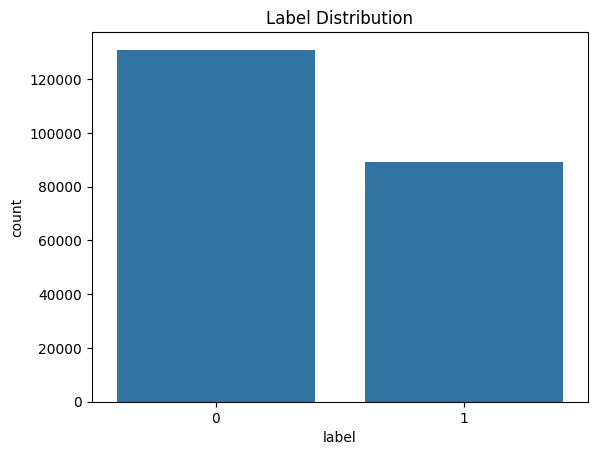

In [4]:
# Analyze binary label distribution
sns.countplot(x='label', data=train_labels)
plt.title('Label Distribution')
plt.show()

Lets load a sample image from the training set and see inspect it visually, as well as check its size

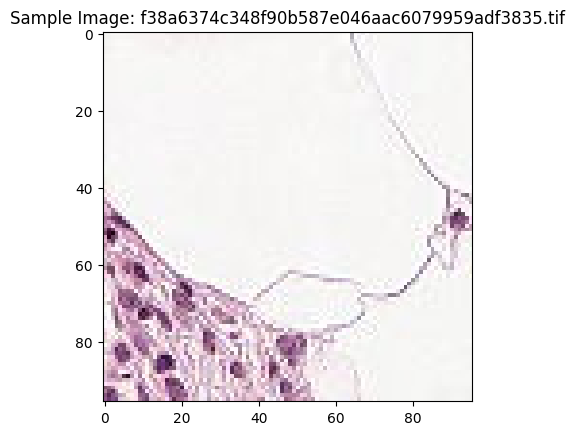

In [5]:
# Inspect training image
sample_image_name = train_labels['id'].iloc[0] + ".tif"
sample_image_path = os.path.join(train_img_dir, sample_image_name)

# Load and display the image
image = cv2.imread(sample_image_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f"Sample Image: {sample_image_name}")
plt.show()

In [6]:
# Check image shape
print(f"Image shape: {image.shape}")

Image shape: (96, 96, 3)


Now that we've inspected the image visually, lets see how the pixel distribution looks on a histogram

Image shape: (96, 96, 3)


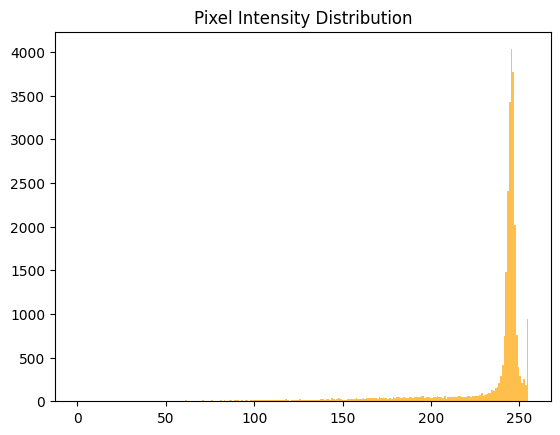

In [7]:
print(f"Image shape: {image.shape}")
plt.hist(image.ravel(), bins=256, color='orange', alpha=0.7)
plt.title('Pixel Intensity Distribution')
plt.show()

### Validate the Data
here we are checking that the data we have is uniform and uncorrupted

In [8]:
# Verify that all images are the same shape
shapes = []
for file in os.listdir(train_img_dir):
    image_path = os.path.join(train_img_dir, file)
    image = cv2.imread(image_path)
    shapes.append(image.shape)

unique_shapes = set(shapes)
if len(unique_shapes) == 1:
    print("All images have the same shape:", unique_shapes)
else:
    print("Different image shapes found:", unique_shapes)

All images have the same shape: {(96, 96, 3)}


In [9]:
# Verify that all labels in CSV have corresponding images
df = pd.read_csv(labels_path)
image_files = set(os.listdir(train_img_dir))
csv_images = set(df['id'].apply(lambda x: f"{x}.tif"))

missing_in_dir = csv_images - image_files
missing_in_csv = image_files - csv_images

if missing_in_dir:
    print("Images in CSV but missing in directory:", missing_in_dir)
if missing_in_csv:
    print("Images in directory but missing in CSV:", missing_in_csv)

if csv_images == image_files:
    print("Images in CSV and in directory")

Images in CSV and in directory


In [10]:
# Check for corrupt images
for file in os.listdir(train_img_dir):
    image_path = os.path.join(train_img_dir, file)
    try:
        image = cv2.imread(image_path)
        if image is None:
            print(f"Corrupt image detected: {file}")
            os.remove(image_path)
    except Exception as e:
        print(f"Error reading image {file}: {e}")

## Model Architecture
For this project we will first look at a simpler CNN, LeNet-5, and then run some more complex models like ResNet50 and VGG16

In [11]:
# Prepare image file paths and labels
image_paths = [os.path.join(train_img_dir, f"{img_id}.tif") for img_id in train_labels['id']]
labels = train_labels['label'].astype(str)  # Convert labels to string format

# Split data into training and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

In [12]:


# Image data generator for training and validation
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True)

# Data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_paths[:1000], 'class': train_labels[:1000]}),
    x_col='filename',
    y_col='class',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': val_paths[:200], 'class': val_labels[:200]}),
    x_col='filename',
    y_col='class',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

Found 1000 validated image filenames belonging to 2 classes.


Found 200 validated image filenames belonging to 2 classes.


#### LeNet_5_model

In [30]:
LeNet_5_model = Sequential([
    Conv2D(6, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
LeNet_5_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
LeNet_5_history = LeNet_5_model.fit(
    train_generator,
    epochs=3,
    validation_data=val_generator
)



Epoch 1/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5952 - loss: 0.6644 - val_accuracy: 0.6050 - val_loss: 0.6249
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6099 - loss: 0.6223 - val_accuracy: 0.7350 - val_loss: 0.5882
Epoch 3/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7167 - loss: 0.5987 - val_accuracy: 0.7200 - val_loss: 0.5289


#### VGG16 Model

In [14]:
VGG16_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

VGG16_model = Sequential([
    VGG16_base_model,
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(4096, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
VGG16_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
VGG16_history = VGG16_model.fit(
    train_generator,
    epochs=3,
    validation_data=val_generator
)

Epoch 1/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.4956 - loss: 10.7393 - val_accuracy: 0.5950 - val_loss: 0.6812
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.5781 - loss: 0.6831 - val_accuracy: 0.6100 - val_loss: 0.6436
Epoch 3/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.5140 - loss: 0.7048 - val_accuracy: 0.6100 - val_loss: 0.6783


#### ResNet50

In [15]:
ResNet50_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

ResNet50_model = Sequential([
    ResNet50_base_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
ResNet50_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
ResNet50_history = ResNet50_model.fit(
    train_generator,
    epochs=3,
    validation_data=val_generator
)

Epoch 1/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.6953 - loss: 2.6317 - val_accuracy: 0.6100 - val_loss: 35488.7617
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7646 - loss: 0.5838 - val_accuracy: 0.6100 - val_loss: 377661.9688
Epoch 3/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7831 - loss: 0.5640 - val_accuracy: 0.6100 - val_loss: 45164.3984


Looking at the validation accuracy of each model shows us that LeNet-5 is performing better than ResNet50 and VGG16

## Results and Analysis

### Hyperparameter Tuning

Now that we have taken a look at the model options, lets make a class to iterate through each of them with various hyperparameters to see the which configurations provide the best results

Tuning LeNet-5...
Reloading Tuner from models/LeNet-5/tuner0.json
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7794 - loss: 0.4800
Tuning VGG16...
Reloading Tuner from models/VGG16/tuner0.json
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 309ms/step - accuracy: 0.5644 - loss: 0.6844
Tuning ResNet50...
Reloading Tuner from models/ResNet50/tuner0.json
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.6228 - loss: 49596415868928.0000
Best Model: LeNet-5
--------------------
Best Hyperparameters: {'filters1': 16, 'filters2': 64, 'dense_units1': 256, 'learning_rate': 0.00029273330707146596}


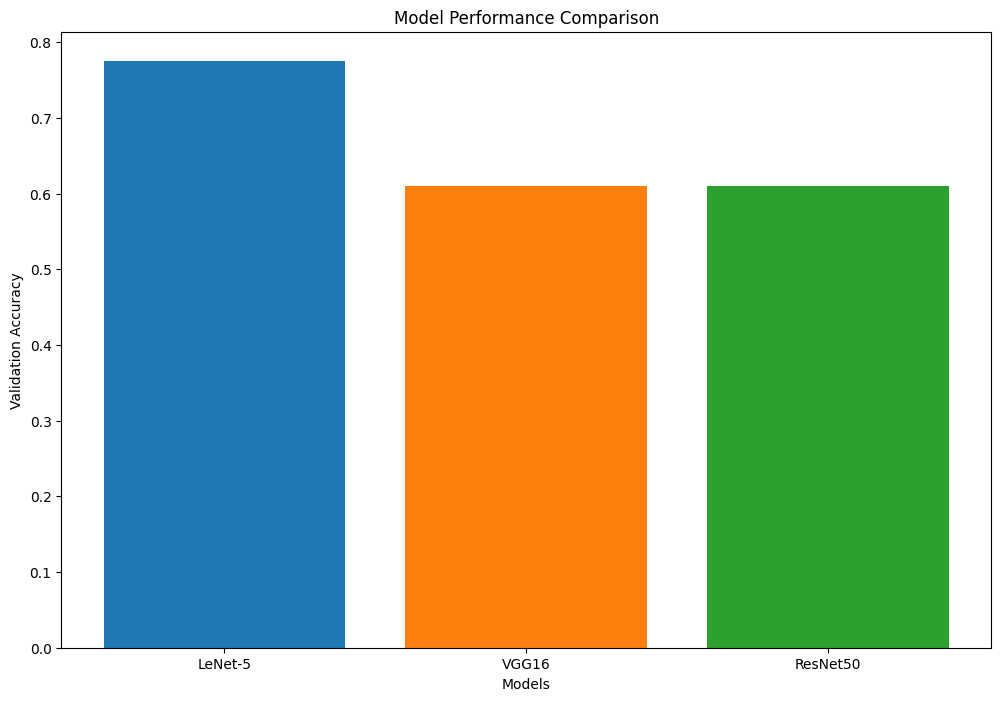

In [28]:
# Define the hypermodel for tuning
class HyperModel(kt.HyperModel):
    def __init__(self, model_name):
        self.model_name = model_name
    
    def build(self, hp):
        model = Sequential()
        
        if self.model_name == 'LeNet-5':
            model.add(Conv2D(hp.Int('filters1', 16, 64, 16), (3, 3), activation='relu', input_shape=(96, 96, 3)))
            model.add(MaxPooling2D((2, 2)))
            model.add(Conv2D(hp.Int('filters2', 32, 128, 32), (3, 3), activation='relu'))
            model.add(MaxPooling2D((2, 2)))
            model.add(Flatten())
            model.add(Dense(hp.Int('dense_units1', 128, 512, 128), activation='relu'))
            model.add(Dense(1, activation='sigmoid'))

        elif self.model_name == 'VGG16':
            base_model = VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
            model.add(base_model)
            model.add(Flatten())
            model.add(Dense(hp.Int('dense_units', 1024, 4096, 1024), activation='relu'))
            model.add(Dense(1, activation='sigmoid'))

        elif self.model_name == 'ResNet50':
            base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
            model.add(base_model)
            model.add(Flatten())
            model.add(Dense(hp.Int('dense_units', 512, 2048, 512), activation='relu'))
            model.add(Dense(1, activation='sigmoid'))

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return model

# Define a function to search for the best hyperparameters
def tune_hyperparameters(model_name, train_generator, val_generator):
    tuner = kt.RandomSearch(
        HyperModel(model_name),
        objective='val_accuracy',
        max_trials=1,
        executions_per_trial=1,
        directory='models',
        project_name=model_name
    )

    tuner.search(
        x=train_generator,
        validation_data=val_generator,
        epochs=3,
        callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
    )

    best_model = tuner.get_best_models(num_models=1)[0]
    best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

    trials = tuner.oracle.get_best_trials()
    val_accuracies = []
    for trial in trials:

        val_accuracy = trial.metrics.metrics['val_accuracy'].get_last_value()
        val_accuracies.append(val_accuracy)

    return best_model, best_hyperparameters.values, val_accuracies

# Main function to evaluate all models and plot performance
def evaluate_and_plot_models():
    models = ['LeNet-5', 'VGG16', 'ResNet50']
    performance_data = {}
    best_model = None
    best_hyperparameters = None
    best_accuracy = 0


    for model_name in models:
        print(f"Tuning {model_name}...")
        model, hyperparameters, accuracies = tune_hyperparameters(model_name, train_generator, val_generator)
        performance_data[model_name] = accuracies
        
        val_accuracy = model.evaluate(val_generator)[1]
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = model_name
            best_hyperparameters = hyperparameters
    
    print("="*20)
    print("Best Model:", best_model)
    print("-"*20)
    print("Best Hyperparameters:", best_hyperparameters)
    print("="*20)

    # Plotting the results
    plt.figure(figsize=(12, 8))
    for model_name, accuracy in performance_data.items():
        plt.bar(model_name, accuracy)
    
    plt.xlabel('Models')
    plt.ylabel('Validation Accuracy')
    plt.title('Model Performance Comparison')
    plt.show()

evaluate_and_plot_models()


From these results we can see that for our small sample, LeNet-5 has out performed VGG16 and ResNet50. Now we can take the best parameters, train our model and run it against our test data.

In [39]:
final_model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])
# Compile the model
final_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00029273330707146596),
    loss='binary_crossentropy',
      metrics=['accuracy'])

# Train the model
LeNet_5_history = final_model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator
)

final_model.save('final_model.h5')


Epoch 1/30


/home/dillonkyle/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.5386 - loss: 0.9817 - val_accuracy: 0.7450 - val_loss: 0.6553
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.6549 - loss: 0.6461 - val_accuracy: 0.6400 - val_loss: 0.5986
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.6600 - loss: 0.6087 - val_accuracy: 0.6450 - val_loss: 0.5784
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.7059 - loss: 0.5702 - val_accuracy: 0.8000 - val_loss: 0.5319
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.7275 - loss: 0.5521 - val_accuracy: 0.7450 - val_loss: 0.5107
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.7595 - loss: 0.5079 - val_accuracy: 0.7900 - val_loss: 0.4786
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.7670 - loss: 0.4888 - val_accuracy: 0.7700 - val_loss: 0.4813
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.7761 - loss: 0.4879 - val_accuracy: 0.7950 - val_loss

In [40]:
model = load_model('final_model.h5')

def prepare_image_data(image_paths, target_size=(96, 96), batch_size=1):
    datagen = ImageDataGenerator(rescale=1./255)
    df = pd.DataFrame({'filename': image_paths})
    print("Dataframe head:\n", df.head())

    generator = datagen.flow_from_dataframe(
        dataframe=df,
        x_col='filename',
        directory=None,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=None,
        shuffle=False
    )
    
    print(f"Number of images in generator: {generator.samples}")
    return generator

def predict_images_and_save_to_csv(directory, output_csv='predictions.csv'):
    image_files = [fname for fname in os.listdir(directory) if fname.lower().endswith(('.tif'))]
    image_paths = [os.path.join(directory, fname) for fname in image_files]
    
    if not image_paths:
        raise ValueError("No images found in the directory.")

    generator = prepare_image_data(image_paths)
    
    try:
        predictions = model.predict(generator, verbose=1)
    except ValueError as e:
        print("Error during prediction:", e)
        return
    
    predicted_classes = (predictions > 0.5).astype(int)
    filenames = [os.path.splitext(os.path.basename(f))[0] for f in generator.filenames]
    
    data = {
        'id': filenames,
        'labels': predicted_classes.flatten()
    }
    
    df = pd.DataFrame(data)
    df.to_csv(output_csv, index=False)
    print(f"Results saved to {output_csv}")

directory = 'test'
predict_images_and_save_to_csv(directory)


Dataframe head:
                                             filename
0  test/ee047a838f40414f24a21a167c630c1118609a23.tif
1  test/a8689bd2893f686c843bcd6e9dd30a7af3b2efe8.tif
2  test/61530def268d65283218c3dcc9d3bfe36717993e.tif
3  test/85b3001b6819eb0543c4649c8e515db92fd2b562.tif
4  test/6d9c0135f4c2f59b42333539408d7304cdae214c.tif
Found 57458 validated image filenames.
Number of images in generator: 57458
   24/57458 ━━━━━━━━━━━━━━━━━━━━ 4:14 4ms/step  

/home/dillonkyle/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57458/57458 ━━━━━━━━━━━━━━━━━━━━ 256s 4ms/step
Results saved to predictions.csv


## Conclusion

Due to the nature of the dataset consisting of small resolution images, it was not suprising to see that the simpler LeNet-5 model outperformed the complex ResNet50 models. I was only able to run very few epochs for the more complex models, so in the future I would look into either optimizing them to run on lower resources or dedicate a larger machine to running them so that I could get a more accurate comparision.

## References
(1) Excerpt from https://www.kaggle.com/c/histopathologic-cancer-detection/overview
(2) Excerpt from https://www.kaggle.com/c/histopathologic-cancer-detection/overview